## Работа с изображениями

In [2]:
import os
import random

import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
import torchvision.transforms as transforms

from torchvision import models
from torchvision import utils

from sklearn.metrics import classification_report, f1_score

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

sns.set_theme()

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


### Загрузим данные

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)

[torchvision.datasets.CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)




> The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.





In [ ]:
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)
testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)


trainset, valset = random_split(trainset, lengths=[40000, 10000])
train_indices = torch.randperm(len(trainset))[:10000]
trainset = Subset(trainset, train_indices)

train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

val_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

test_loader = torch.utils.data.DataLoader(
    valset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
len(trainset), len(valset), len(testset)

(10000, 10000, 10000)

### Посмотрим на них...

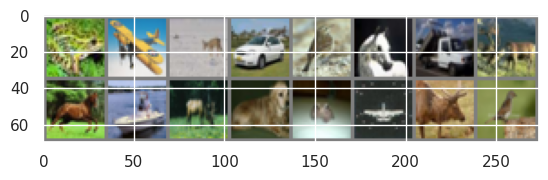

frog 
plane
deer 
car  
bird 
horse
truck
deer 
horse
ship 
deer 
dog  
frog 
plane
deer 
bird 


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('\n'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
images[0].shape

torch.Size([3, 32, 32])

### Утилиты для обучения

In [ ]:
def train_model(model, num_epochs=100, eval_freq=10):
  train_loss_history, eval_loss_history = [], []
  train_f1_history, eval_f1_history = [], []
  global_step = 0

  model.train()
  for epoch in tqdm(range(num_epochs)):
      for batch_X, target in train_loader:
        optimizer.zero_grad()
        logits = model(batch_X.to(device))
        loss = loss_function(logits, target.to(device))
        loss.backward()
        optimizer.step()

        preds =  torch.argmax(logits, 1).cpu().tolist()
        f1 = f1_score(preds, target.cpu().numpy().tolist(), average='weighted')

        train_loss_history.append((global_step, loss.item()))
        train_f1_history.append((global_step, f1))

        if global_step % eval_freq == 0:
              val_loss, val_f1 = evaluate(model)
              eval_loss_history.append((global_step, val_loss))
              eval_f1_history.append((global_step, val_f1))
              model.train()

        if global_step % 250 == 0:
              clear_output(True)

              plt.figure(figsize=(15, 5))

              plt.subplot(121)
              plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
              if len(eval_loss_history):
                  plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
              plt.legend()

              plt.subplot(122)
              plt.plot(*zip(*train_f1_history), alpha=0.5, label='train_f1')
              if len(eval_f1_history):
                  plt.plot(*zip(*eval_f1_history), color='red', label='eval_f1')
              plt.legend()
              plt.show()
        global_step += 1

  return model

In [ ]:
@torch.no_grad()
def evaluate(model, mode='eval'):
    model.eval()

    dataloader = val_loader if mode == 'eval' else test_loader

    loss_epoch = 0.
    num_epoch = 0.
    preds_list = []
    targets_list = []

    for batch_X, target in dataloader:
      logits = model(batch_X.to(device))
      loss = loss_function(logits, target.to(device))
      num = logits.shape[0]
      loss_epoch += loss.item() * num
      num_epoch += num

      preds_list += torch.argmax(logits, 1).cpu().tolist()
      targets_list += target.cpu().numpy().tolist()

    f1 = f1_score(preds_list, targets_list, average='weighted')

    return loss_epoch / num_epoch, f1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Полносвязная нейронная сеть



<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/modified_model.png" width="600">

In [ ]:
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.layers_stack(x)

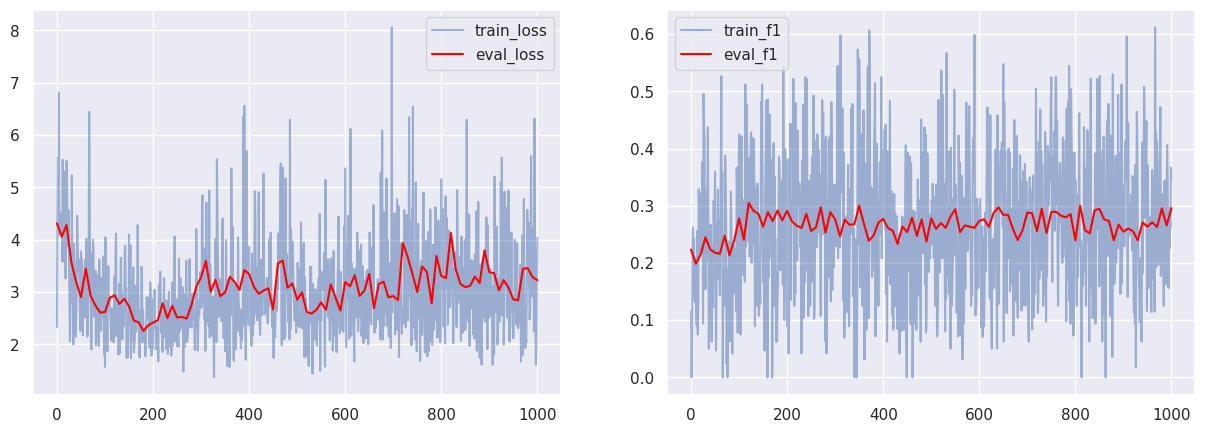

In [ ]:
loss_function = nn.CrossEntropyLoss()

fc_model = FCNet().to(device)
optimizer = optim.AdamW(fc_model.parameters(), lr=0.01)
model = train_model(fc_model, num_epochs=2)

In [ ]:
evaluate(fc_model, mode='test')

(3.1017369159698487, 0.2727530871503814)

Визуализируем веса первого слоя:

In [ ]:
W1 = fc_model.layers_stack[1].weight.reshape(64, 3, 32, 32)  # layer has 64 neurons
img_grid = utils.make_grid(W1, pad_value=1, normalize=True, nrow=16)

plt.figure(figsize=(20, 12))
plt.title("Weights visualization in 2D")
plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())  # CHW -> HWC
plt.axis("off")
plt.show()

### Проблема - нарушение связей между соседними пикселями

При вытягивании изображения в вектор мы теряем информацию о взаимном расположении пикселей на исходной картинке.





 <img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/img_to_vector_problem.png" width="900">

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

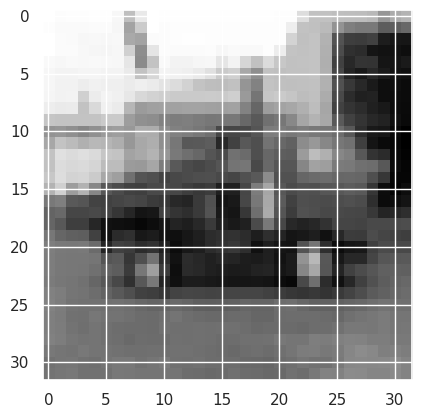

In [ ]:
image = images[0].mean(axis=0)
plt.imshow(image, cmap="gray")
plt.show()

[0.98692816, 0.9633987, 0.96601313, 0.9712418, 0.97647065, 0.97647065, 0.9267974, 0.5267974, 0.827451, 0.9843137, 0.97908497, 0.97908497, 0.97908497, 0.97908497, 0.97908497, 0.97908497, 0.97908497, 0.97908497, 0.97908497, 0.97908497, 0.9712418, 0.96862745, 0.7411764, 0.5424837, 0.5372549, 0.5189543, 0.51111114, 0.503268, 0.47450984, 0.22614382, 0.3803922, 0.43790853, 0.96601313, 0.9450981, 0.9477124, 0.95032674, 0.9555556, 0.95816994, 0.9163399, 0.32549024, 0.6130719, 0.98692816, 0.9633987, 0.9712418, 0.96862745, 0.96862745, 0.96862745, 0.96862745, 0.9712418, 0.9712418, 0.9712418, 0.96601313, 0.96862745, 0.861438, 0.54771245, 0.53464055, 0.48758173, 0.21568632, 0.06928108, 0.024836639, 0.032679778, -0.1738562, -0.1607843, -0.09542481, 0.9816993, 0.95816994, 0.95032674, 0.9294117, 0.93202615, 0.9294117, 0.93202615, 0.36993468, 0.33333337, 0.9529412, 0.9633987, 0.9712418, 0.9738562, 0.9738562, 0.9712418, 0.96862745, 0.96601313, 0.96601313, 0.96601313, 0.96601313, 0.96601313, 0.675817, 0.

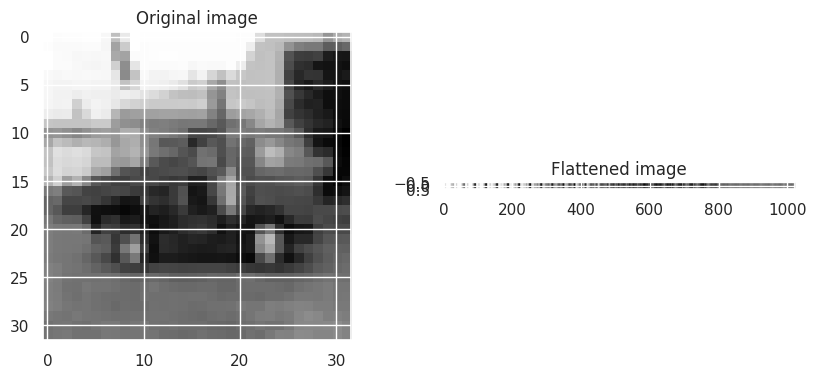

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].imshow(image, cmap="gray")
ax[1].imshow(image.reshape(1, -1), aspect=20, cmap="gray")
ax[0].set_title("Original image")
ax[1].set_title("Flattened image")

vector = np.array(image).flatten()
print(list(vector))

Пиксели, которые были соседними и составляли цельный объект, могут оказаться на большом расстоянии внутри результирующего вектора. Получается, что мы просто удалили информацию об их близости, важность которой нам как людям очевидна.

#### Рецептивное поле

В полносвязной сети каждый нейрон "видит" сразу все изображение (все данные). Наша зрительная система работает иначе.

*  Каждый фоторецептор на сетчатке нашего глаза (палочка или колбочка) реагирует только на свет, попавший на него.

* Сигнал от фоторецептора попадает на нейрон следующего уровня ([биполярная клетка](https://ru.wikipedia.org/wiki/%D0%91%D0%B8%D0%BF%D0%BE%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D0%B5_%D0%BA%D0%BB%D0%B5%D1%82%D0%BA%D0%B8_%D1%81%D0%B5%D1%82%D1%87%D0%B0%D1%82%D0%BA%D0%B8)). Этот нейрон уже соединен с несколькими фоторецепторами. Область, в которой они локализованы, называется **рецептивным полем**.
Нейрон возбуждается при определенной комбинации сигналов от связанных с ним рецепторных клеток. По сути, он реагирует на простой, локально расположенный паттерн.

* Клетки уровнем выше (ганглиозные) собирают информацию с нескольких близко расположенных биполярных клеток и активируются при уникальной комбинации сигналов с них. Их рецептивное поле больше, и паттерны, на которые они реагируют, сложнее.

**Рецептивное поле** нейрона — это участок с рецепторами, с которых он прямо или опосредованно, через другие нейроны, получает информацию.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/brain.png" width="1000">

* Далее сигнал передается в мозг, но там связи между нейронами продолжают оставаться иерархическими. Рецептивное поле нейронов растет, и паттерны, на которые они активируются, становятся все более и более сложными.

#### Скользящее окно (фильтр)

Получается, что можно не подавать на вход нейрона первого слоя информацию о всем изображении сразу, а "показать" ему только часть картинки, чтобы он научился распознавать простые, но универсальные паттерны. А их агрегация произойдет в последующих слоях.

Для этого используется так называемое "скользящее окно", которое двигается по изображению, захватывая на каждом шаге только небольшую область.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/convolution_with_filter.gif" width="600">

#### Фильтры размытия

Такой подход используют, например, при наложении графических **фильтров**. Вы наверняка пользовались ими, если работали в графических редакторах, например, в Photoshop.



Простейший фильтр — это [Box blur](https://en.wikipedia.org/wiki/Box_blur), который просто усредняет значения соседних пикселей.

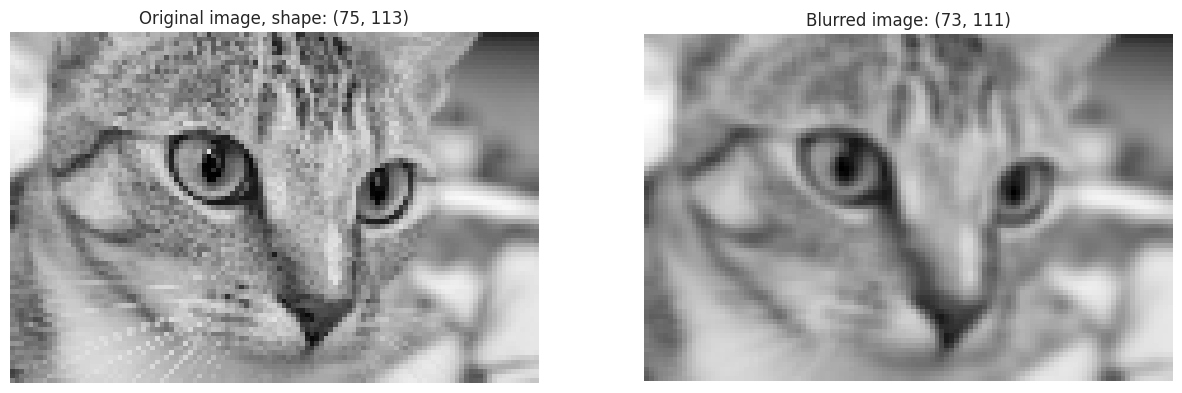

In [ ]:
from skimage import data, color
from skimage.transform import rescale


box_blur_kernel = 1/9 * np.array([[1, 1, 1],
                                  [1, 1, 1],
                                  [1, 1, 1]])

def apply_filter(img, kernel):
    h, w = np.array(img.shape)  # image height and width
    kh, kw = np.array(kernel.shape)  # kernel height and width (3x3)
    # Calculate the output size
    out = np.zeros((h - kh + 1, w - kw + 1))
    for i in range(h - kh + 1):
        for j in range(w - kw + 1):
            # Get 3x3 patch from image
            patch = img[i : i + kh, j : j + kw]
            # Elementwise multiply patch pixels to kernel weights and sum
            new_pixel = np.multiply(patch, kernel).sum()
            # Store modified pixel in new blurred image
            out[i, j] = new_pixel
    return out


def show(img, result):
    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(img, cmap="gray")
    axes[1].imshow(out, cmap="gray")
    axes[0].set(title=f"Original image, shape: {img_cat_resc.shape}")
    axes[1].set(title=f"Blurred image: {out.shape}")
    axes[0].axis("off")
    axes[1].axis("off")
    plt.show()


img_cat = color.rgb2gray(data.cat())
img_cat_resc = rescale(img_cat, 0.25, anti_aliasing=False) * 255

out = apply_filter(img_cat_resc, box_blur_kernel)
show(img_cat_resc, out)

Таким образом, для получения нового изображения мы применили формулу:

$$\large \text{output}(x,y) =  \sum_{i}^{H} \sum_{j}^{W}k[i,j] I[x+j,y+i],$$

где $H, W$ — высота и ширина ядра фильтра, $I$ — исходное изображение.


#### Фильтры для обнаружения паттернов

Такой же алгоритм можно применять не для сглаживания изображения, а для поиска (выделения) на нем чего-либо (например, контуров объектов). Для этого достаточно заменить ядро фильтра.

In [ ]:
sobel_y_kernel = torch.tensor([[ 1.0,  2.0, 1.0 ],
                               [ 0.0,  0.0, 0.0 ],
                               [-1.0, -2.0, -1.0]])

x_edges = apply_filter(img_cat * 255, sobel_y_kernel)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img_cat, cmap="gray")
axes[1].imshow(x_edges, cmap="gray", vmin=0, vmax=255)
axes[0].set(title=f"Original image, shape: {img_cat.shape}")
axes[1].set(title=f"Horizontal edges detector: {x_edges.shape}")
axes[0].axis("off")
axes[1].axis("off")
plt.show()

Мы применили к изображению [фильтр Cобеля](https://en.wikipedia.org/wiki/Sobel_operator), а точнее, одно из его ядер, дающее отклик на перепад яркости по горизонтали.

"Отклик" — это величина яркости, которую мы получили на результирующем изображении.

Можно запрограммировать свой фильтр, который будет искать произвольный объект.
Например, найдем крест на на изображении:

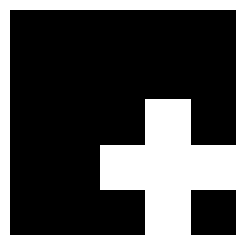

In [ ]:
cross = np.array([[0, 0 ,0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 0]])

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.axis("off")
plt.show()

Для этого создадим фильтр размером с объект ($3 \times 3$). В точках, где должны быть пиксели, принадлежащие объекту, поместим положительные значения, а там, где должен быть фон, — отрицательные.



In [ ]:
kernel_cs = np.array([[-1, 1, -1],
                      [ 1, 1,  1],
                      [-1, 1, -1]])

При попадании такого фильтра на объект отрицательные значения обнулятся при перемножении с пикселями фона, а положительные — просуммируются и дадут высокий отклик.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/cross_filter.png" width="900">


Проверим :

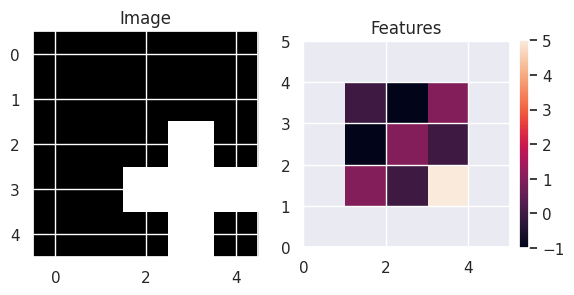

Features:
 [[ 0. -1.  1.]
 [-1.  1.  0.]
 [ 1.  0.  5.]]


In [ ]:
features = apply_filter(cross, kernel_cs)

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.imshow(features, extent=(1, 4, 1, 4))
plt.title("Features")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()
print("Features:\n", features)

Такого рода фильтров люди придумали довольно много. Есть [детектор углов Харриса](https://en.wikipedia.org/wiki/Harris_Corner_Detector) или [признаки Хаара](https://en.wikipedia.org/wiki/Haar-like_feature), которые успешно использовались для [обнаружения лиц](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework) на фотографиях. Это примеры случаев, когда людям удалось подобрать удачные ядра фильтров для решения конкретных задач.

Мы хотим, чтобы модель могла обучаться решать различные задачи. И вместо того, чтобы вручную создавать фильтры, мы будем подбирать их значения **в процессе обучения**.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/mlp_vs_cnn.png" width="1000">

Тогда модель сможет выучивать шаблоны для небольших фрагментов изображения и станет инвариантной к сдвигу.

#### Свертка с фильтром

Операцию применения фильтра к изображению будем называть *сверткой*.

По своей сути операция свёртки — это та же самая взвешенная сумма с добавлением свободного члена, используемая в полносвязных линейных слоях.

Выполним свертку при помощи помощи линейного слоя: заменим код внутри цикла линейным слоем и убедимся, что результат вычислений не поменялся.

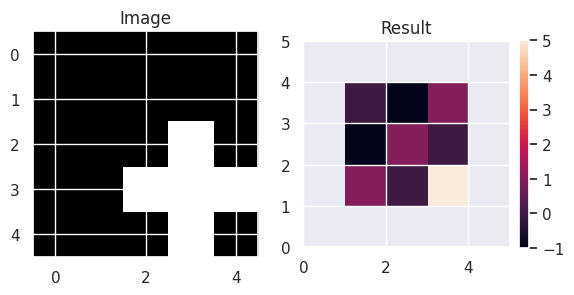

Result:
 tensor([[ 0., -1.,  1.],
        [-1.,  1.,  0.],
        [ 1.,  0.,  5.]])


In [ ]:
local_linear = nn.Linear(9, 1, bias=False)  # 9 = 3 * 3

local_linear.weight.data[0] = torch.tensor(kernel_cs).flatten()
cross_in_tensor = torch.tensor(cross).float()
result = torch.zeros((3, 3))
for i in range(0, result.shape[0]):
    for j in range(0, result.shape[1]):
        segment = cross_in_tensor[i : i + 3, j : j + 3].flatten()
        result[i, j] = local_linear(segment)

plt.subplot(1, 2, 1)
plt.imshow(cross, cmap="gray")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.imshow(result.detach(), extent=(1, 4, 1, 4))

plt.title("Result")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()
print("Result:\n", result.detach())

Ключевое отличие между линейным слоем и свёрткой заключается в том, что каждый нейрон линейного слоя получает на вход всё изображение сразу, а свёртка — небольшие фрагменты.

Так как при свертке для каждого фрагмента получаем свой отклик (признак), то для всего изображения получим уже массив признаков (feature map).




<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/neuron_output.png" width="700">

### Сверточный слой нейросети

В PyTorch есть класс `nn.Conv2d`, который реализует операцию свертки для целого изображения.

[nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

In [ ]:
cross = np.array([[0, 0 ,0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 0]])

kernel_cs = np.array([[-1, 1, -1],
                      [ 1, 1,  1],
                      [-1, 1, -1]])

cross_in_tensor = torch.tensor(cross).float()

In [ ]:
from torch.nn import Conv2d

conv = Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=(3, 3),
    bias=False,
)

# conv2d accepts input of shape BxCxHxW
feature_map = conv(
    cross_in_tensor.unsqueeze(0).unsqueeze(0)  # HxW -> BxCxHxW
)  # add batch and channel dim
print(feature_map)

tensor([[[[ 0.0000,  0.2339, -0.0323],
          [ 0.2339,  0.4190,  0.7960],
          [ 0.2174,  1.0447,  0.4799]]]], grad_fn=<ConvolutionBackward0>)


Так как изначально ядро нашего единственного фильтра (нейрона) инициализированно случайными небольшими значениями, то на выходе получается набор ничего не значащих чисел. Убедимся, что слой работает так, как мы ожидали, подменив ядро:

In [ ]:
# data[0] because filter can have multiple kernels. see next chapter
conv.weight.data[0] = torch.tensor(kernel_cs)  # replace original kernel

feature_map = conv(
    cross_in_tensor.unsqueeze(0).unsqueeze(0)
)  # add batch and channel dim
print("Feature map for cross\n", feature_map)

Feature map for cross
 tensor([[[[ 0., -1.,  1.],
          [-1.,  1.,  0.],
          [ 1.,  0.,  5.]]]], grad_fn=<ConvolutionBackward0>)


При создании экземпляра объекта класса `nn.Conv2D` помимо размера ядра (`kernel_size`) мы передали в конструктор еще два параметра:

`in_channels = 1 ` и `out_channels = 1`

Разберемся, что они означают.

#### Обработка цветных/многоканальных изображений

`in_channels` — это количество каналов входного тензора (изображения).

В примерах выше мы рассматривали черно-белые изображения. Их также называют одноканальными изображениями, т. к. в них цвет пикселя определяется одним числом, характеризующим яркость. Хранятся они в двумерном массиве размером $[H,W]$.

Цветные изображения хранятся в трехмерных массивах $[H,W,C]$ (для формата numpy, OpenCV) или $[C,H,W]$ (тензорный формат PyTorch), где $C$ — количество цветовых каналов.

Для $\text{RGB}$-изображений $C=3$.

Так как `Conv2d` рассчитан на работу с многоканальным входом, то в коде выше нам пришлось написать дополнительный `unsqueeze(0)`, чтобы добавить к тензору с изображением это $3$-е измерение, т. е. перевести $[H,W]$ в $[C,H,W]$, где $C = 1$.

Важно, что для каждого канала будет создано дополнительное ядро фильтра.

In [6]:
conv_ch1 = Conv2d(in_channels=1, out_channels=1, kernel_size=5)
print("One channel kernel \t", conv_ch1.weight.shape)
conv_ch3 = Conv2d(in_channels=3, out_channels=1, kernel_size=5)
print("Three channel kernel \t", conv_ch3.weight.shape)

One channel kernel 	 torch.Size([1, 1, 5, 5])
Three channel kernel 	 torch.Size([1, 3, 5, 5])


Опробуем трехканальную свертку на цветном изображении:

In [1]:
!wget -q https://ic.pics.livejournal.com/lique_bez/68678182/107635/107635_800.jpg

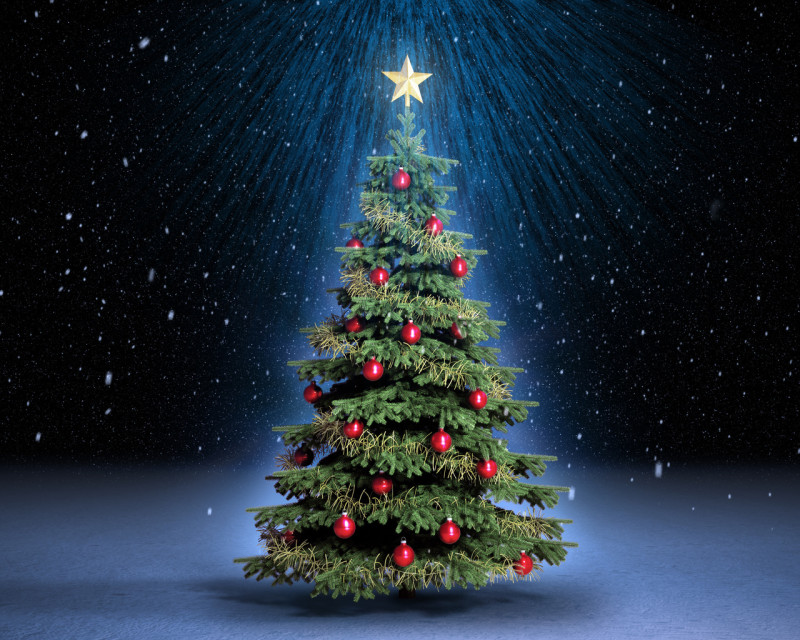

In [3]:
from PIL import Image

tree = Image.open("107635_800.jpg")
display(tree)

Изображение из формата Pillow надо превратить в `torch.Tensor`:

In [7]:
tree_in_np = np.array(tree)  # pillow -> numpy
tree_in_float = tree_in_np.astype(np.float32) / 255  # int->float
tree_in_tensor = torch.tensor(tree_in_float)  # np -> torch

try:
    conv_ch3(tree_in_tensor.unsqueeze(0))  # add batch dimension
except Exception as e:
    print("Error: \n", e)

Error: 
 Given groups=1, weight of size [1, 3, 5, 5], expected input[1, 640, 800, 3] to have 3 channels, but got 640 channels instead


Получили ошибку, связанную с количеством каналов. Дело в том, что в PyTorch, в отличие от OpenCV, TensorFlow и ряда других библиотек, каналы (RGB) идут в первом, а не в последнем измерении тензора, описывающего картинку.

OpenCV, TensorFlow, Pillow, etc. : $[\text{Batch}, \text{Height}, \text{Width}, \text{Channels}]$

PyTorch : $[\text{Batch}, \text{Channels}, \text{Height}, \text{Width}]$

Придется сделать дополнительное преобразование, чтобы каналы оказались на том месте, где их ожидает PyTorch:

In [ ]:
print("Original \t", tree_in_tensor.shape, "HWC")
tree_in_tensor_channel_first = tree_in_tensor.permute(2, 0, 1)  # HWC -> CHW
print("Torch style \t", tree_in_tensor_channel_first.shape, "CHW")

Original 	 torch.Size([640, 800, 3]) HWC
Torch style 	 torch.Size([3, 640, 800]) CHW


Теперь можно подать изображение на вход модели, предварительно добавив batch-размерность:

In [ ]:
one_image_batch = tree_in_tensor_channel_first.unsqueeze(0)  # CHW -> BCHW, B = 1
out = conv_ch3(one_image_batch)
print("No error!")

No error!


Нет необходимости проделывать все эти манипуляции вручную, так как в `torchvision.transforms.v2` реализованы функции [to_image](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToImage.html) и  [to_dtype](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToDtype.html), которые последовательно выполняют  преобразования массива типа `np.array` или `Pillow.image` в класс `Image`, а затем в в `torch.Tensor`.

Убедимся, что тензор, преобразованный нами вручную, и тензор, получившийся после применения функции `to_image` и `to_dtype`, совпали:

In [ ]:
from torchvision.transforms.v2.functional import to_image, to_dtype


tree_in_image = to_image(tree)  # convert np.array to PIL.image
tree_in_tensor2 = to_dtype(
    tree_in_image, dtype=torch.float32, scale=True
)  # auto HWC -> CHW

print(tree_in_tensor2.shape)

print(
    "Tensor almost equal: ",
    torch.allclose(tree_in_tensor_channel_first, tree_in_tensor2),  # float comparsion
)

torch.Size([3, 640, 800])
Tensor almost equal:  True


Теперь посмотрим на форму выхода, полученного нами ячейкой выше:

In [ ]:
print("Output feature map size:", out.shape)  # first dim is batch

Output feature map size: torch.Size([1, 1, 636, 796])


Такую размерность имеет выход  **единственного нейрона** в нашем сверточном слое.

На входе несколько каналов (3), на выходе остался один канал.
Как же комбинируются результаты сверток в разных каналах?



<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/convolution_rgb.png" width="700">


Результаты сверток всех ядер фильтра с соответствующими входными каналами просто суммируются:

$\large \displaystyle \text{feature_map}(x,y) = \sum_{c}^{C} \sum_{i}^{H} \sum_{j}^{W}k_c[i,j]I_c[x+j,y+i] + \text{bias},$

$C$ — количество каналов,

$H, W$ — высота и ширина ядра фильтра,

$K_c$ — ядро для канала $c$,

$I$ — изображение (массив $C\times H\times W$),

$I_c$ — канал изображения номер $c$ (срез массива $I$, соответствующий каналу изображения номер $c$).

В силу коммутативности суммы не важно, в каком порядке будут складываться элементы. Можно считать, что каждый элемент входа сначала умножается на свой коэффициент из ядра, а уже затем все суммируется.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/rgb_image_convolution_filter.png" width = "650">

Так выглядит выход одного нейрона, который задается несколькими ядрами и  смещением (bias).

При этом bias  **один** на весь фильтр.

In [ ]:
print("Kernels", conv_ch3.weight.shape)
print("Biases", conv_ch3.bias.shape)

Kernels torch.Size([1, 3, 5, 5])
Biases torch.Size([1])


Входные данные не всегда будут трехканальными цветными RGB-изображениями, в которых цвет пикселя определяется тремя числами, характеризующими три основных цвета (красный, зеленый и синий).

Входной тензор может иметь произвольное количество каналов. Например: марсоход Opportunity для получения изображений использовал [13 каналов](https://habr.com/ru/post/160621/).

Более того, в качестве входного тензора можно использовать не входное изображение, а **карту признаков (feature map)** с выхода предыдущего сверточного слоя.


#### Использование нескольких фильтров

Возвращаемся ко второму параметру конструктора `nn.Conv2D` —
`out_channels = 1`. Этот параметр задает количество фильтров слоя. То есть количество выходных карт признаков всегда совпадает с `out_channels` сверточного слоя.

In [ ]:
from torch.nn import Conv2d

In [ ]:
conv35 = Conv2d(in_channels=3, out_channels=5, kernel_size=3)
out = conv35(tree_in_tensor_channel_first)

print(f"weights shape: {conv35.weight.shape}")  # 5 filters 3x3x3
print(f"bias shape: {conv35.bias.shape}")  # one bias per filter

weights shape: torch.Size([5, 3, 3, 3])
bias shape: torch.Size([5])


В линейном слое каждый нейрон учился активироваться на некий шаблон, например, красную машину или смотрящую направо лошадь.

Мы хотим, чтобы нейроны сверточного слоя также активировались на различные паттерны. Для каждого паттерна нам нужен свой нейрон $⇒$ свой фильтр.

 Каждый нейрон сформирует свою карту признаков размера $1\times H_{out}\times W_{out}$. А на выходе слоя будет их конкатенация:

In [ ]:
print(f"result shape: {out.shape}")  # 5 feature maps

result shape: torch.Size([5, 638, 798])


При объединении этих карт получится тензор размерности $C_{out}\times H_{out} \times W_{out}$, где $C_{out}$ — количество фильтров.

Для **примера с Blur** $C_{out} = 1$, т. е. полученное сглаженное изображение представляет собой одну карту признаков после прохождения через сверточный слой с константным фильтром.

На изображении ниже продемонстрирован результат применения сверточного слоя,
содержащего $5$ фильтров, к изображению из CIFAR-10.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/convolution_layer_with_5_filters.png" width="400">

Стоит отметить, что, в отличие от полносвязного слоя, свёрточный слой не требует информации о количестве значений во входном представлении и может быть использован как для представлений $C_{in} \times 32 \times 32$, так и для $C_{in} \times 100 \times 100$. Словом, представления могут иметь практически любой размер, главное, чтобы пространственные размеры не были меньше размеров ядра свёртки.



#### Уменьшение размера карты признаков

Карта признаков после применения функции активации может быть передана на вход следующей операции свёртки.

In [ ]:
from torch.nn.functional import relu

conv_1 = torch.nn.Conv2d(
    in_channels=3,  # Number of input channels (3 for RGB images)
    out_channels=6,  # Number of filters/output channels
    kernel_size=5,
)

conv_2 = torch.nn.Conv2d(
    in_channels=6,
    out_channels=10,
    kernel_size=5,
)

img = torch.randn((1, 3, 32, 32))  # 1-batch size, 3-num of channels, (32,32)-img size
print(f"img shape: {img.shape}")

out_1 = conv_1(img)
print(f"out_1 shape: {out_1.shape}")

out_2 = conv_2(relu(out_1))
print(f"out_2 shape: {out_2.shape}")

img shape: torch.Size([1, 3, 32, 32])
out_1 shape: torch.Size([1, 6, 28, 28])
out_2 shape: torch.Size([1, 10, 24, 24])


Заметим, что после свёртки ширина $W_{out}$ и высота $H_{out}$ **карты признаков** будут отличаться от **пространственных размерностей** $W_{in}$ и $H_{in}$ исходного тензора. К примеру, при обработке трёхканального тензора размера $32\times32$ ядром размера $5\times5$ можно будет произвести лишь $27$ сдвигов $(32 - 5)$ по вертикали и столько же по горизонтали. Но при этом размер итоговой карты признаков будет равен $28 \times 28$, поскольку первый ряд (либо столбец) можно получить без сдвигов по вертикали либо горизонтали соответственно. При повторном применении фильтра размер каждой из сторон уменьшится ещё на $4$.

Итоговое значение $N'$ пространственной размерности $N$ для квадратного фильтра $K \times K$ фильтра $F$ вычисляется по следующей формуле:
$$\large N' = N - K + 1$$.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/decrease_size_of_image_after_convolution.png" width="700">

Заметим, что при уменьшении размера представлений пиксели, находящиеся около краёв, участвуют в значительно меньшем количестве свёрток, чем пиксели в середине, хотя информация в них не обязательно менее ценна, чем информация из центральных пикселей. К примеру, пиксель в верхнем левом углу представления вне зависимости от размера фильтра будет принимать участие лишь в одной свёртке, и информация о нём будет сохранена лишь в верхнем левом углу нового представления.

#### Дополнение (padding)

Для борьбы с описанной выше проблемой применяется *дополнение* входного тензора (англ. *padding*). В ходе него ширина и высота тензора увеличиваются за счёт приписывания столбцов и строк с некоторыми значениями. К примеру, на изображении ниже перед свёрткой ядром размера $3\times3$ был применён padding нулями.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/padding.png" width="250">

На примере убедимся, что это позволит нам сохранить пространственные размерности тензоров.

In [ ]:
img = torch.randn((1, 1, 5, 5))  # create random image BCHW
print(f"Original tensor:\nshape:{img.shape}")
conv_3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conved_3 = conv_3(img)
print("Shape after convolution layer(kernel 3x3):", conved_3.shape)

Original tensor:
shape:torch.Size([1, 1, 5, 5])
Shape after convolution layer(kernel 3x3): torch.Size([1, 1, 3, 3])


Карта признаков меньше, чем вход. Теперь добавим padding:

In [ ]:
# Add zeros to image manually
padded_img = torch.zeros((1, 1, 7, 7))  # create zeros array to insert image in center
padded_img[:, :, 1:-1, 1:-1] += img  # insert image, we get image arounded by zeros
print(f"\nPadded tensor:\nshape:{padded_img.shape}:\n {padded_img}")

conved_pad_3 = conv_3(padded_img)
print("\n\nPadded shape:", padded_img.shape)
print("Shape after convolution with padding(kernel 3x3):", conved_pad_3.shape)


Padded tensor:
shape:torch.Size([1, 1, 7, 7]):
 tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.1908, -0.7478, -0.8099,  0.5146, -0.9317,  0.0000],
          [ 0.0000,  1.1590, -0.1007,  0.2772, -0.6910,  0.7533,  0.0000],
          [ 0.0000, -0.0365, -0.2935,  0.7834,  0.5399, -0.0517,  0.0000],
          [ 0.0000, -0.3422,  0.1283,  0.1790, -1.2840,  0.3508,  0.0000],
          [ 0.0000, -0.5096, -0.1003,  0.3166, -0.6447, -0.6397,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]]])


Padded shape: torch.Size([1, 1, 7, 7])
Shape after convolution with padding(kernel 3x3): torch.Size([1, 1, 5, 5])


Размер выхода равен размеру входа.

Однако если мы увеличим размер ядра до $5\times5$, то увидим, что, несмотря на padding, выход снова стал меньше входа:

In [ ]:
conv_5 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

conved_pad_5 = conv_5(padded_img)

print("Original shape:", img.shape)
print("Shape after convolution with padding(kernel 5x5):", conved_pad_5.shape)

Original shape: torch.Size([1, 1, 5, 5])
Shape after convolution with padding(kernel 5x5): torch.Size([1, 1, 3, 3])


Дополнение одним рядом и одним столбцом не является универсальным решением: для фильтра размером $5$ размер выходного тензора всё равно отличается от входного. Если мы немного видоизменим полученную выше формулу (используя размер дополнения $P$), то получим:
$$\large N' = N + 2\cdot P - K + 1$$

Для того, чтобы пространственные размеры не изменялись ($N' = N$), для разных размеров фильтра требуются разные размеры дополнения. В общем случае для размера фильтра $K$ требуемый размер дополнения:
$$\large P = \frac{K-1}{2}$$




Теперь реализуем padding, используя инструменты библиотеки PyTorch, и сравним его с ручным добавлением padding:

In [ ]:
# conv layer without padding (padding=0 by default)
conv_3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)

# conv layer with padding = 1 (add zeros)
conv_3_padded = torch.nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=3, padding=1
)
original = conv_3(padded_img)
padded = conv_3_padded(img)

print(f"Explicitly padded:\n{original.shape}")
print(f"\nImplicitly padded:\n{padded.shape}")

Explicitly padded:
torch.Size([1, 1, 5, 5])

Implicitly padded:
torch.Size([1, 1, 5, 5])


Кроме чисел параметр `padding` может принимать значение `"same"` — тогда padding будет рассчитан автоматически так, чтобы размер выходного тензора не отличался от размера входного тензора, или `"valid"` — отсутствие дополнения.

По умолчанию `padding = 0`, а если его изменить на целочисленное значение, то края тензора будут дополняться нулями, как в примерах выше. Это тоже не универсальный способ обработки краев изображения при свертках. Есть модификации: например, в [numpy.pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) есть зеркальный padding или заполнение средним значением.

### Сверточная нейронная сеть

Теперь мы можем заменить часть линейных слоев нашей модели на сверточные. Но если решается задача классификации, то последний слой по-прежнему должен быть линейным.

Поскольку операция свертки является линейной (мы убедились в этом, когда выполняли ее при помощи линейного слоя), то функция активации (например, ReLU) по-прежнему требуется.

>*Так как функция активации применяется к тензору поэлементно, не важно, какую именно форму имеет тензор, а значит и какой слой находился перед ней: полносвязный или сверточный.*


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Поскольку полносвязный слой принимает на вход набор векторов, а сверточный — возвращает набор трёхмерных тензоров, нам нужно превратить эти тензоры в векторы. Для этого используется объект класса [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten).
Он преобразовывает данные на входе в вектор, сохраняя при этом первое (batch) измерение.


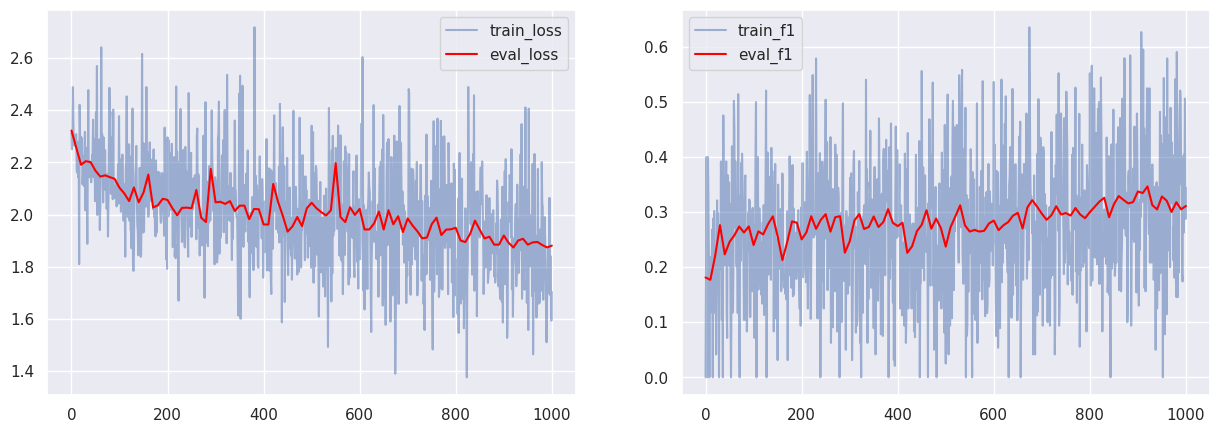

In [ ]:
loss_function = nn.CrossEntropyLoss()

cnn_model = ConvNet().to(device)
optimizer = optim.AdamW(cnn_model.parameters(), lr=0.01)
model = train_model(cnn_model, num_epochs=2)

In [ ]:
evaluate(cnn_model, mode='test')

(1.8204639863967895, 0.3426911797595705)

#### Рецептивные поля нейронов

Нейросетевая модель из предыдущего примера позволяет в общем случае понять структуру свёрточных нейронных сетей: после некоторого количества свёрточных слоёв, извлекающих локальную пространственную информацию, идут полносвязные слои (как минимум в количестве одного), сопоставляющие извлечённую информацию.

Внутри свёрточных слоёв происходит следующий процесс: первые слои нейронных сетей имеют малые рецептивные поля, т. е. им соответствует малая площадь на исходном изображении. Такие нейроны могут активироваться лишь на некоторые простые шаблоны (по типу углов или освещённости).

Нейроны следующего слоя уже имеют большие рецептивные поля, в результате чего в картах признаков появляется информация о более сложных паттернах. С каждым слоем свёрточной нейронной сети рецептивное поле нейронов увеличивается. Увеличивается и сложность шаблонов, на которые может реагировать нейрон. В последних слоях рецептивное поле нейрона должно быть размером со всё исходное изображение. Пример можно увидеть на схеме ниже.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/receptive_field_size.png" width="700">

Если на первом слое рецептивное поле имело размер $K \times K$, то после свёртки фильтром $K\times K$ оно стало иметь размер $(2K-1) \times (2K-1)$, то есть увеличилось на $K-1$ по каждому из направлений. Несложно самостоятельно убедиться, что данная закономерность сохранится при дальнейшем применении фильтров того или иного размера.



Однако при обработке больших изображений нам потребуется очень много слоев, чтобы нейрон "увидел" всю картинку.

К примеру, для изображения $1024\times1024$ понадобится сеть глубиной $\approx510$ сверточных слоев.

Такая модель потребует огромного количества памяти и вычислительных ресурсов.
Чтобы избежать этого, будем сами уменьшать размеры карт признаков, при этом рецептивные поля нейронов будут расти.



#### Шаг свёртки (Stride)

До этого мы двигали фильтр на один пиксель, то есть перемещались с шагом (stride), равным единице.

Если двигать фильтр с большим шагом, то размер выходной карты признаков (feature map) будет уменьшаться кратно шагу, и рецептивные поля нейронов будут расти быстрее.

Для изменения шага свертки в конструкторе `nn.Conv2d` есть параметр `stride`.

In [ ]:
dummy_input = torch.randn(1, 1, 5, 5)
conv_s1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=(1, 1))
conv_s2 = nn.Conv2d(1, 3, 3, stride=2)  # bypass par. names, stride = (2, 2)

out_stride1 = conv_s1(dummy_input)
out_stride2 = conv_s2(dummy_input)

print("Out with stride 1", out_stride1.shape)
print("Out with stride 2", out_stride2.shape)

Out with stride 1 torch.Size([1, 3, 3, 3])
Out with stride 2 torch.Size([1, 3, 2, 2])


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/convolution_parameter_stride.gif" width="350"></center>

<center><em>Свёртка массива $5\times5$ фильтром размером $3\times3$ с шагом $2$ по вертикали и горизонтали</em></center>

Важно заметить, что в некоторых случаях часть данных может не попасть в свёртку. К примеру, при $N = 7,\, K = 3,\, S = 3$. В данном случае: $$\large N' = 1 + \frac{7 - 3}{3} = 2\frac13$$
 В подобных ситуациях часть изображения не захватывается, в чём мы можем убедиться на наглядном примере:

In [ ]:
# Create torch tensor 7x7
input = torch.tensor([[[[1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99],
                        [1, 1, 1, 1, 1, 1, 99]]]], dtype=torch.float)

print(f"input shape: {input.shape}")

conv = torch.nn.Conv2d(
    in_channels=1,  # Number of channels
    out_channels=1,  # Number of filters
    kernel_size=3,
    stride=3,
    bias=False,  # Don't use bias
)
conv.weight = torch.nn.Parameter(
    torch.ones((1, 1, 3, 3))
)  # Replace random weights to ones
out = conv(input)

print(f"out shape: {out.shape}")
print(f"out:\n{out}")

input shape: torch.Size([1, 1, 7, 7])
out shape: torch.Size([1, 1, 2, 2])
out:
tensor([[[[9., 9.],
          [9., 9.]]]], grad_fn=<ConvolutionBackward0>)


Видно, что столбец с числами $99$ просто не попал в свертку.
Поэтому на практике подбирают `padding` таким образом, чтобы при `stride = 1`  размер карты признаков на выходе был равен входу, а затем делают свертку со `stride = 2`.

Казалось бы, с увеличением шага $S$ рецептивное поле не выросло — как увеличивалось с $1$ до $K$, так и увеличивается. Однако обратим внимание на другое: если раньше размерность $N$ становилась $N - K + 1$, то теперь она станет $\displaystyle 1 + \frac{N-K}{S}$.

В результате если раньше следующий фильтр с размером $K'$ имел рецептивное поле:$$\displaystyle N \cdot \frac{K'}{N'} = N \cdot \frac{K'}{N - K + 1},$$

то теперь: $$N \cdot \frac{K'}{N'} = N \cdot \frac{K'}{1 + \dfrac{N-K}{S}}.$$

Понятно, что $$\frac{K'}{N - K + 1} \leq \frac{K'}{1 + \dfrac{N-K}{S}},$$ поэтому рецептивное поле каждого нейрона увеличивается.

#### Визуализация работы свертки

В PyTorch чуть сложнее:

image.png

image.png

[conv_arithmetic наглядно](https://github.com/vdumoulin/conv_arithmetic) с `padding, stride, dilation`

[Немного интерактива](https://ezyang.github.io/convolution-visualizer/)

#### Уплотнение (Субдискретизация, Pooling)

Другим вариантом стремительного увеличения размера рецептивного поля является использование дополнительных слоёв, требующих меньшего количества вычислительных ресурсов. Слои субдискретизации прекрасно выполняют эту функцию: подобно свёртке производится разбиение изображения на небольшие сегменты, внутри которых выполняются операции, не требующие использования обучаемых весов. Два популярных примера подобных операций: получение максимального значения (max pooling) и получение среднего значения (average pooling).

**Важно понимать**, что pooling-слои не являются сверточными слоями, так как в них нет фильтров с обучаемыми весами, т. е. они никак не настриваются в процессе обучения нейросети. Это просто эффективный способ уменьшить пространственные размеры карт признаков.

Аналогично разбиению на сегменты при свёртке, слои субдискретизации имеют два параметра: размер фильтра $K$ (то есть, каждого из сегментов) и шаг $S$ (stride). Аналогично свёрткам, при применении субдискретизации формула размера стороны:
$$N' = 1+ \frac{N-K}{S}.$$

Ниже приведён пример использования операций max pooling и average pooling при обработке массива.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/subdiscretization_pooling.png" width="600">

Реализуем это в коде:

In [ ]:
# create tensor 4x4
input = torch.tensor([[[[1, 1, 2, 4],
                        [5, 6, 7, 8],
                        [3, 2, 1, 0],
                        [1, 2, 3, 4]]]], dtype=torch.float)

max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
avg_pool = torch.nn.AvgPool2d(kernel_size=2, stride=2)

print("Input:\n", input)
print("Max pooling:\n", max_pool(input))
print("Average pooling:\n", avg_pool(input))

Input:
 tensor([[[[1., 1., 2., 4.],
          [5., 6., 7., 8.],
          [3., 2., 1., 0.],
          [1., 2., 3., 4.]]]])
Max pooling:
 tensor([[[[6., 8.],
          [3., 4.]]]])
Average pooling:
 tensor([[[[3.2500, 5.2500],
          [2.0000, 2.0000]]]])


**Важно отметить**, что субдискретизация выполняется по каждому из каналов отдельно, в результате чего количество каналов не меняется, в отличие от применения фильтра при свёртке. К примеру, ниже можно увидеть визуализацию применения max pooling к одному из каналов тензора, имеющего $64$ канала.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/changing_size_of_image_after_pooling.png" width="350">

#### Свёртка фильтром $1\times1$

С помощью субдискретизации и свертки с шагом больше единицы мы можем регулировать пространственные размеры (ширину и высоту) карты признаков.

Обычно если хотят уменьшить количество каналов в карте признаков, то используют свертку с размерами ядра $1\times1$.



Фактически такая свертка — это линейный слой, на вход которому подали все признаки из одной точки входа.

Когда переводим цветное изображение в градации серого, мы делаем похожую операцию: складываем все каналы с коэффициентом $\displaystyle\frac{1}{3}$:

$\text{Brightness} = \dfrac{1}{3} R + \dfrac{1}{3} G + \dfrac{1}{3}B $

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/1_times_1_convolutions_featere_maps.png" width="600">

Количество каналов можно регулировать при помощи параметра `out_channels`. Если при этом количество каналов уменьшается, то таким образом мы обобщаем признаки.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/1_times_1_convolution.png" width="900">

При этом количество таких фильтров $1\times1$ может быть произвольным. Обычно свертку $1\times1$ применяют для уменьшения числа каналов, но и обратная ситуация тоже возможна.

Ниже приведён пример применения такого фильтра с целью снижения количества карт признаков.

In [ ]:
conv = torch.nn.Conv2d(
    in_channels=64,  # number of input channels
    out_channels=32,  # number of filters
    kernel_size=1,
)

input = torch.randn((1, 64, 56, 56))
out = conv(input)

print("Input shape:", input.shape)
print("Shape after 1x1 conv:", out.shape)  # [1, 32, 56, 56] batch, C_out, H_out, W_out

Input shape: torch.Size([1, 64, 56, 56])
Shape after 1x1 conv: torch.Size([1, 32, 56, 56])


### Сравнение свёрточного и полносвязного слоев

Давайте оценим количество ресурсов, которое требуется для обработки одного изображения из CIFAR-10 при помощи сверточного и полносвязного слоя.

Пусть сверточный слой будет содержать $6$ фильтров размером $3 \times 3 $, `padding = 1`, `stride = 1`, а полносвязный — $6$ выходов (как если бы мы делали классификацию $6$-ти классов).

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/conv_vs_linear.png" width="900">

#### Количество обучаемых праметров (весов) свёрточного слоя

Количество параметров в одном фильтре: $C_{in}\times K_{h}\times K_{w} + \text{bias} = 3 \times 3 \times 3 + 1 = 28$

Количество фильтров $C_{out} = 6$

Итого: $(C_{in}\times K_{h}\times K_{w} +1) \times C_{out} = 28 \times 6 = 168$



In [ ]:
from torch.nn import Conv2d


def get_params_count(module):
    weights_count = 0
    # Get all model weights: kernels + biases
    for p in module.parameters():
        print(p.shape)
        # torch.prod - multiply all values in tensor
        weights_count += torch.tensor(p.shape).prod()
    print("Total weights", weights_count.item())


conv = Conv2d(3, 6, 3, bias=True)
get_params_count(conv)

torch.Size([6, 3, 3, 3])
torch.Size([6])
Total weights 168


#### Количество обучаемых праметров полносвязного слоя

1. Данные вытягиваем в вектор:

$\text{inputs_count} = C_{in} \times H_{in} \times W_{in}  = 3*32*32 = 3072$

2. Каждый нейрон (их $6$ шт.) выходного слоя хранит вес для каждого элемента входа ($3072$) и еще одно смещение:

$(\text{inputs_count} + 1) \times \text{outputs_count} = (3072 + 1) \times 6 = 18\ 438$


In [ ]:
from torch.nn import Linear

linear = Linear(3072, 6, bias=True)
get_params_count(linear)

torch.Size([6, 3072])
torch.Size([6])
Total weights 18438


То есть для хранения весов такого линейного слоя нужно в $\approx 100$ раз больше памяти.

#### Количество требуемых вычислительных ресурсов для полносвязного слоя

*Считаем только умножения, т. к. (умножение + сложение = 1 [FLOP](https://en.wikipedia.org/wiki/FLOPS)).*

В полносвязном слое каждый вход умножается на свой вес один раз и количество умножений совпадает с количеством весов за вычетом сложения со смещением:

 $C_{in} × H_{in} × W_{in} × \text{outputs_count}  = 3 × 32 \times 32 × 6 = 18 \ 432 $

#### Количество требуемых вычислительных ресурсов для свёрточного слоя

1. Разовое применение фильтра эквивалентно применению линейного слоя с таким же количеством весов:

$C_{in} \times K_{h} \times K_{w} \times C_{out} = 3 \times 3 \times 3 \times 6 = 162$

Т. е. умножаем каждый вес фильтра на вход.

2. Сдвигаем фильтр и повторяем п. 1 для каждой точки на карте признаков:

$C_{in} \times K_{h} \times K_{w} \times C_{out} \times H_{out} \times W_{out}   = 162 \times 32 \times 32  = 165\ 888 $

То есть количество операций в $\approx 10$ раз больше, чем у полносвязного слоя.

**Выводы**:
выигрыш по количеству параметров при использовании свёрточного слоя омрачается большим количеством операций перемножения. Это было проблемой в течение долгого времени, пока вычисление операции свёртки не перевели на видеокарты. При выполнении свёртки одного сегмента не требуется информация о результатах свёртки на другом сегменте, поэтому данные операции можно выполнять параллельно, с чем как раз прекрасно справляются видеокарты.

### Общая структура свёрточной нейронной сети

Теперь мы можем более детально взглянуть на типичную архитектуру свёрточной нейронной сети. Как ранее уже обсуждалось, в первую очередь необходимо последовательностью свёрточных слоёв и уплотнений достичь того, чтобы каждый элемент карты признаков имел большое рецептивное поле, а значит мог отвечать за большие и сложные шаблоны. Затем данные карты признаков выпрямляются в векторы и передаются в полносвязные слои, последовательность которых, используя глобальную информацию, возвращает значение целевой переменной.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/neural_network_architecture.png" width="800">

В результате количество признаков уменьшается от слоя к слою.

**Важно отметить** следующие эмпирические соображения по созданию собственной архитектуры сверточной нейросети:

* В первом сверточном слое сети обычно происходит резкое увеличение карт признаков с 1 или 3 (черно-белое или цветное изображение соответственно) до 16 и более.
* В последующих сверточных слоях периодически **пространственные размеры карт признаков уменьшают вдвое** (за счет pooling-слоев или за счет свертки с шагом $2$).
* Одновременно с уменьшением пространственных размеров карт признаков вдвое, **количество карт признаков увеличивают вдвое**.
* Полносвязные слои (FC) ставятся в конце сети в количестве обычно не больше двух. Они нужны только для формирования предсказаний на основе признаков, качественно извлеченных сверточной частью сети. FC слои сами по себе имеют большое число параметров, и при использовании большого количества полносвязных слоев модель может оказаться перепараметризована. Перепараметризация модели может приводить к переобучению, особенно при малом размере обучающей выборки.

### LeNet: пример архитектуры сверточной сети

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/lenet_architecture.png" width="900">

Примером сети, построенной по такой архитектуре, является LeNet.
Она была разработана в 1989 г. [Яном Ле Куном](https://en.wikipedia.org/wiki/Yann_LeCun). Сеть имела 5 слоев с обучаемыми весами, из них 2 — сверточные.

Применялась в США для распознавания рукописных чисел на почтовых конвертах до начала 2000 г.

[LeNet PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)


Процесс обучения почти не отличается от обучения полносвязной сети, используются такие же оптимизатор и функция потерь.

### AlexNet: пример архитектуры сверточной сети

image.png

 Сеть с большим отрывом выиграла конкурс по распознаванию изображений ImageNet LSVRC-2012 в 2012 году (с количеством ошибок 15,3% против 26,2% у второго места).

 Архитектура AlexNet схожа с созданной Yann LeCum сетью LeNet. Однако у AlexNet больше фильтров на слое и вложенных сверточных слоев.

## Визуализация


Чтобы лучше понять, как работают сверточные сети, можно визуализировать карты признаков и веса фильтров свёртки.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/what_hidden_layers.png" width="1000">

### Визуализация весов

Веса фильтров на первом слое легко визуализировать. И результат легко интерпретируется, так как у фильтров такое же количество каналов, как и у цветных изображений ($3$ канала).

Ниже приведен пример того, как это можно сделать для обученной модели AlexNet из зоопарка моделей torchvision.

Чтобы понять, через какие свойства можно получить доступ к весам, выведем структуру модели

In [ ]:
alexnet = models.alexnet(weights="AlexNet_Weights.DEFAULT")
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 110MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Видно, что первый слой — это $0$-й элемент контейнера `features`.
Веса слоя хранятся в `weight.data`.

In [ ]:
weight_tensor = alexnet.features[0].weight.data  # extract weights
print("Weights shape", weight_tensor.shape)

Weights shape torch.Size([64, 3, 11, 11])


Чтобы отобразить все веса на одном изображении, воспользуемся вспомогательной функцией `make_grid` из `torchvision.utils`

На вход метод получает `batch` изображений ($B \times C \times H \times W$) в формате `torch.Tensor` и визуализирует их в форме таблице.

In [ ]:
img_grid = utils.make_grid(
    (weight_tensor + 1) / 2, pad_value=1
)  # combine weights from all channel into table, note remapping to (0,1) range
print("Output is CxHxW image", img_grid.shape)

Output is CxHxW image torch.Size([3, 106, 106])


`make_grid` часто используют, чтобы отображать изображения в TensorBoard.

А чтобы отобразить получившуюся таблицу в блокноте средствами matplotlib, нам потребуется поменять порядок хранения данных, поместив каналы на первое место.

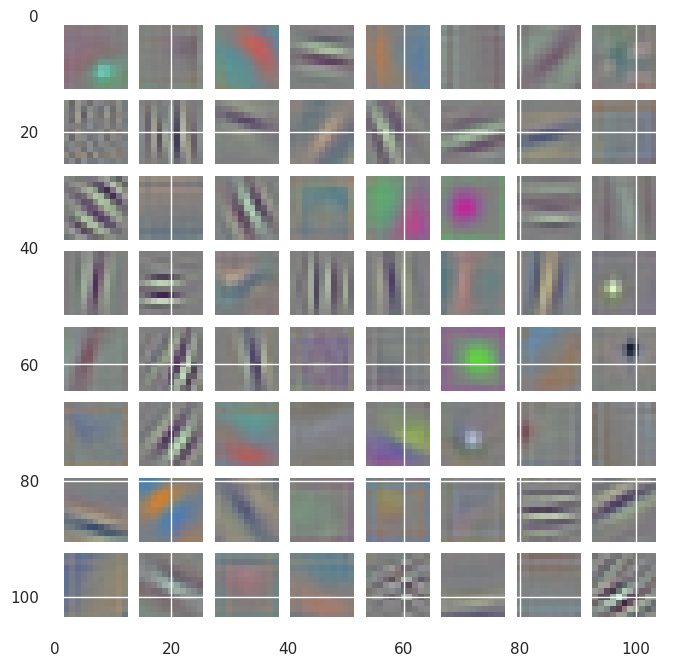

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(
    np.transpose(img_grid, (1, 2, 0))
)  # change channel order for compability with numpy & matplotlib
plt.show()

Видно, что модель научилась улавливать простые геометрические формы: края под разными углами, точки того или иного цвета. Фильтры AlexNet'а оказались настолько большими, что частично захватили не только простую локальную информацию, но и сложные градиенты или решётки.


#### Визуализация фильтров промежуточных слоев

К сожалению, выполнить ту же операцию для фильтров на скрытых слоях едва ли представляется разумным: в отличие от трёхканальных фильтров первого слоя, веса которых легко визуализировать, фильтры поздних слоёв имеют гораздо больше каналов, что затрудняет их визуализацию. Пожалуй, единственным вариантом  является поканальное отображение весов, которое довольно сложно трактовать. Убедимся в этом, на примере ниже.

**Higher Layer: Visualize Filter**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L06/weight_visualization.png" width="700"></center>

<center><em> We can visualize filters at higher layers, but not that interesting</em></center>

<center><em>Source: <a href="https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html">ConvNetJS CIFAR-10 example</a></em></center>

Визуализируем веса $2$-го сверточного слоя AlexNet.
Слой доступен через `features[3] `

In [ ]:
weights_of_conv2_layer = alexnet.features[3].weight.data  # extract weights
print(weights_of_conv2_layer.shape)

torch.Size([192, 64, 5, 5])


В нем $192$ фильтра, в каждом $64$ ядра. Поэтому ограничимся первым фильтром и выведем все его ядра.

In [ ]:
first_filter_kernels = weights_of_conv2_layer[0]
print(first_filter_kernels.shape)

torch.Size([64, 5, 5])


Чтобы использовать `image_grid`, входной тензор должен иметь формат $(B \times C \times H \times W)$. Поэтому добавим размерность, соответствующую каналам:

In [ ]:
img_grid = utils.make_grid(
    weights_of_conv2_layer[0].unsqueeze(1), pad_value=1  # add fake channel dim
)

plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(
    np.transpose((img_grid + 1) / 2, (1, 2, 0))
)  # change channel order for compability with numpy
plt.show()

Интерпретация такой визуализации довольно затруднительна, зато мы разобрались, как получать доступ к весам.

### Визуализация активаций

Наиболее очевидный метод визуализации заключается в том, чтобы показать активации сети во время прямого прохода. Для сетей ReLU активации обычно начинают выглядеть относительно сгущенными и плотными, но по мере развития обучения они обычно становятся более редкими и локализованными.

На последних слоях свёрточной нейронной сети размеры рецептивных полей нейронов становятся сравнимы с размером исходного изображения, поэтому при визуализации их карт признаков становится понятно, какие нейроны реагируют на какие части изображений.

К примеру, на изображении ниже активация выделенного нейрона достигнута благодаря пикселям, примерно соответствующим расположению лица человека, поэтому можно предположить, что он научился находить лица на изображении. Более подробно об этом можно почитать в статье [Understanding Neural Networks Through Deep Visualization 🎓[arxiv]](https://arxiv.org/abs/1506.06579).

**Visualizing Activations**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L06/visualization_activations.png" width="500"></center>

<center><em> conv5 feature map is $128\times13\times13$; visualize as $128$ $13\times13$ grayscale images</em></center>

<center><em>Source: <a href="http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf">Visualizing and Understanding</a></em></center>

В отличие от весов, карты признаков не сохраняются в памяти. Получим к ним доступ с помощью хуков




Напишем хук, который выведет нам карту признаков.
Так как на выходе данного слоя $256$ каналов, выведем каждый отдельно, подав на вход `make_grid` тензор с $256$ элементами.

Для этого потребуется:
* удалить batch-измерение,
* добавить измерение, имитирующее канал для картинок.




In [ ]:
def module_hook(module: nn.Module, input, output):
    activation_map = input[0].permute(1, 0, 2, 3)  # B <--> C
    img_grid = (
        utils.make_grid(activation_map, pad_value=1, nrow=16, normalize=True) * 255
    )
    plt.rcParams["figure.figsize"] = (8, 8)
    plt.imshow(
        img_grid.permute(1, 2, 0)
        .numpy()
        .astype("uint8")  # change channel order for compability with numpy
    )
    plt.show()


handle = alexnet.features[12].register_forward_hook(module_hook)

Чтобы карта признаков  была интерпретируема, надо использовать реальное изображение

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.imshow(tree)
plt.axis("off")
plt.show()

Преобразуем изображение в тензор и подадим на вход модели:

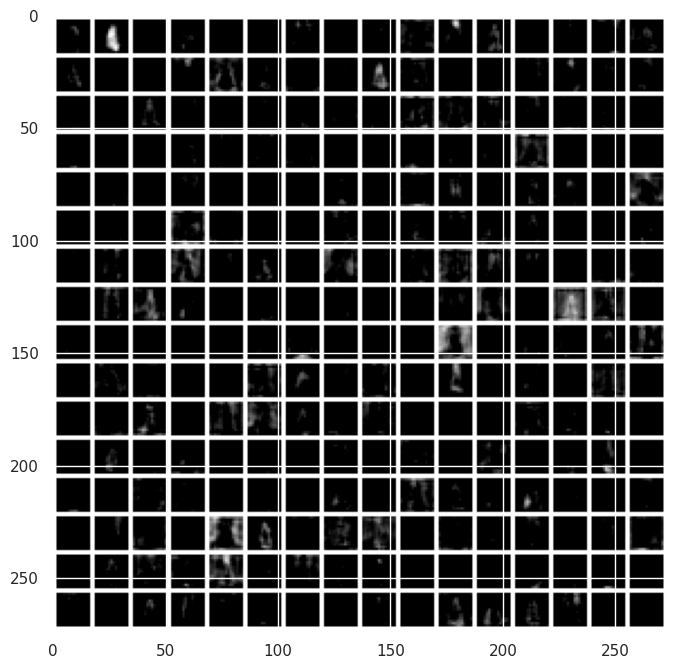

In [ ]:
from torchvision.transforms import v2


transform = v2.Compose(
    [
        v2.Resize((256, 256)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

tensor = transform(tree)
out = alexnet(tensor.unsqueeze(0))

Единственная опасная ловушка, которую можно легко заметить с помощью этой визуализации, заключается в том, что некоторые карты признаков могут быть равны нулю для многих различных входов. Это может указывать на мертвые фильтры и быть симптомом слишком высокой скорости обучения.

Отключим наш hook, чтобы он не мешал дальнейшим экспериментам:

In [ ]:
handle.remove()

Существуют техники, которые позволяют визуализировать паттерн, на который лучше всего активируется конкретный нейрон. Они основаны на подсчете градиента не по весам, а по входу (изображению) и его постепенной модификации.

Примеры:

* [Exploring Neural Networks with Activation Atlases](https://distill.pub/2019/activation-atlas/)

* [Feature Visualization](https://distill.pub/2017/feature-visualization/)


## Feature extractor

Перейдем к картам признаков предпоследнего слоя. В AlexNet предпоследний слой полносвязный, соответственно, активации — это вектор.

На вход сети мы подали изображение, закодированное при помощи $150528$ чисел ($224\times224\times3 = 150528$), а на выходе получили вектор из $4096$ чисел.

Фактически нейросеть понизила размерность наших данных (в $\approx36$ раз). При этом данные в векторе достаточно информативны, так как позволяют произвести классификацию на $1000$ классов.

Такие векторы признаков называются **embedding** и широко используются.

**Последний слой**

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L06/out/feature_extractor.png" width="1000">

Чтобы убедиться в полезности полученных представлений, кластеризуем их при помощи [k-nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) алгоритма.




**Последний слой: ближайшие соседи**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L06/last_layer_knn.jpg" width="900"></center>

<center><em>Source: <a href="https://cs231n.stanford.edu/slides/2023/lecture_13.pdf">CS231: Self-Supervised Learning</a></em></center>

Чтобы получить embedding изображения, отключим последний слой. Выведем структуру модели, чтобы найти его:

In [ ]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

И заменим его пустышкой `nn.Identity()` — класс, который возвращает вход без изменений:

In [ ]:
alexnet.classifier[6] = nn.Identity()

Загрузим датасет:

In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

transform = v2.Compose(
    [
        v2.Resize(224),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

testset = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)
train, test, _ = random_split(testset, [512, 128, 10000 - 512 - 128])
train_loader = DataLoader(train, batch_size=128, shuffle=False, drop_last=True)

100%|██████████| 170M/170M [00:29<00:00, 5.74MB/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10


Добавим функцию, которая сохраняет выходы измененной модели в массиве, а также возвращает метки классов:

In [ ]:
from tqdm import tqdm


def get_embeddings(loader):
    embeddings = []
    labels = []
    for img, label in tqdm(loader):
        emb = alexnet(img)
        embeddings.append(emb.detach())
        labels.append(label)
    embeddings = torch.stack(embeddings).reshape(-1, 4096).numpy()
    labels = torch.stack(labels).flatten().numpy()
    return embeddings, labels

Превратим картинки в векторы признаков:

In [ ]:
%%time
x, y = get_embeddings(train_loader)

100%|██████████| 4/4 [00:17<00:00,  4.33s/it]

CPU times: user 16.1 s, sys: 1.28 s, total: 17.3 s
Wall time: 17.3 s


Теперь у нас есть $512$ векторов по $4096$ значения в каждом и $512$ меток классов:

In [ ]:
print(x.shape, y.shape)

(512, 4096) (512,)


"Обучим" на них k-NN:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x, y)

KNeighborsClassifier()

Получим векторы признаков (embeddings) для тестовых картинок:

In [ ]:
%%time

test_loader = DataLoader(test, batch_size=32, shuffle=False, drop_last=True)
test_emb, gt_labels = get_embeddings(test_loader)

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

CPU times: user 3.87 s, sys: 19.3 ms, total: 3.89 s
Wall time: 3.89 s


Получаем предсказания и считаем accuracy:

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = neigh.predict(test_emb)

accuracy = accuracy_score(gt_labels, y_pred)
print("k-NN accuracy", accuracy)

k-NN accuracy 0.4609375


Как видим, активации на последних слоях сети достаточно информативны.